In [1]:
# import the basic packages
import pandas as pd
import numpy as np
import pickle

import re
import stopwordsiso
from stopwordsiso import stopwords
import jieba
import opencc
from opencc import OpenCC

import stopwordsiso
from stopwordsiso import stopwords
stopwords(["zh"])  # Chinese
from collections import Counter
import re

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# 1. Import data and preprocessing the raw data

In [2]:

df_ = pd.read_csv('bigdataFinal.csv')
df_.index.names = ['id']
df_.head()

,﻿Date,Subject,From,From Email,To,Cc,Bcc,Body
id,,,,,,,,
0,09/05/2017 05:51:48,(中日)使用者發出的信件取回問題-接續問題,Ciou-Liang,kevin@patech.com.tw,service@mailcloud.com.tw,NaN,NaN,Dear 網擎：\r\n 附件所示 郵件使用者 alex.chen@cr...
1,﻿02/27/2018 05:28:12,(仍然無法註冊) Re: M2k - danno149131 - 註冊帳號顯示錯誤,Mail2000 客服中心,m2k_adm@mail2000.com.tw,cloud_se@openfind.com.tw,m2k_service <m2k_service@mail2000.com.tw>,NaN,"您好，使用者反應重新註冊帳號，將訂單送出時，系統會顯示""認證失敗，請重新確認您所輸入的帳號密..."
2,﻿04/18/2018 02:55:09,(希望今天能收到回覆) P-Marker 業務問題 - 潛在客戶：國民健康署,Mail2000 客服中心,m2k_adm@mail2000.com.tw,產品業務 <sales@openfind.com.tw>,m2k_service <m2k_service@mail2000.com.tw>,NaN,您好，國民健康署張淇鈞 小姐02-2522 0889rubychang@hpa.gov.tw...
3,﻿05/05/2016 08:45:46,(很急) Fw: (急) MailGates 軟體 - 嘉聯益科技 - 稽核條件沒有正常執行,Mail2000 客服中心,m2k_adm@mail2000.com.tw,網擎資訊技術服務信箱 <m2k_noc@openfind.com.tw>,m2k_service <m2k_service@mail2000.com.tw>,NaN,您好，客戶來電表示還沒收到回覆，今天上午也有寄信到m2k_noc，麻煩您幫忙盡快連繫，謝謝。...
4,﻿12/15/2016 01:54:47,(很急) Fw: Mail2000 軟體 - 德律科技 - 管理者帳號疑似被入侵,Mail2000 客服中心,m2k_adm@mail2000.com.tw,網擎資訊技術服務信箱 <m2k_noc@openfind.com.tw>,m2k_service <m2k_service@mail2000.com.tw>,NaN,您好，德律陳先生0933 818 259問題：客戶提到管理者帳號被登入，想確認系統設定是否有...


In [3]:
# Convert list Simple Chinese stopword to Traditional stopword 
stop_words = list(stopwords(["zh"]))
stopa = []
for i in stop_words:
    cc = OpenCC('s2t')
    texta = cc.convert(i)
    stopa.append(texta)

In [4]:
def preprocessingTextFull(text, sep = ' '):
# regex
    text = text.lower()
    text = re.sub(r'&lt;', '', text) #remove '&lt;' tag
    text = re.sub(r'<.*?>', '', text) #remove html
    text = re.sub(r'[^\w\s]', '', text) #remove punctiation
    text = re.sub('[^\u4e00-\u9fa5]+', '', text) # remove ASCII strings
    # remove stopword
    more_s = ['幫','忙', '請','謝', '謝', '您','好','姓','名', '_','喔','想','感','問','題','没','沒','為',
             "客","服","信","箱","電","子","目","前","公","司","服","務","郵","件","心", "擎","先",
              "生","軟","體","謝","教","育","教","育","雲","科","技","國","鼎","新","高","雄","市",
              "民","政","局","台","南","糖","網","擎","急","安","泰","兆","豐","可","口","可","樂","口","樂","濟","部","飯","店","潛","客","戶",
             "邱","良","姐","咖","啡", '附',
              '歡','迎','次','寶',"瘦", "仍","然",'彰','化', "工","業",'企','業', '聯','絡','工','提','供','孟', '秋', '東', '際', '睿', '明']

    stop = stopa  + more_s
    text = "".join([word for word in text if word not in stop]) #remove stopwords
    
    for c in ['\r', '\n', '\t'] :
        text = re.sub(c, ' ', text) #replace newline and tab with tabs\
        text = re.sub('\s+', ' ', text) #replace multiple spaces with one space
        
    text_cut = sep.join(jieba.cut(text, cut_all=False))
    
    return text_cut


In [5]:
df_.isnull().sum()

﻿Date            0
Subject          0
From            13
From Email      83
To              86
Cc             303
Bcc           2558
Body             1
dtype: int64

In [6]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ﻿Date       2558 non-null   object 
 1   Subject     2558 non-null   object 
 2   From        2545 non-null   object 
 3   From Email  2475 non-null   object 
 4   To          2472 non-null   object 
 5   Cc          2255 non-null   object 
 6   Bcc         0 non-null      float64
 7   Body        2557 non-null   object 
dtypes: float64(1), object(7)
memory usage: 160.0+ KB


In [7]:
df1 = df_.drop(columns = ['From','From Email', 'To', 'Cc','Bcc'], axis = 0)

In [8]:
df = df1.dropna()

In [9]:
df

,﻿Date,Subject,Body
id,,,
0,09/05/2017 05:51:48,(中日)使用者發出的信件取回問題-接續問題,Dear 網擎：\r\n 附件所示 郵件使用者 alex.chen@cr...
1,﻿02/27/2018 05:28:12,(仍然無法註冊) Re: M2k - danno149131 - 註冊帳號顯示錯誤,"您好，使用者反應重新註冊帳號，將訂單送出時，系統會顯示""認證失敗，請重新確認您所輸入的帳號密..."
2,﻿04/18/2018 02:55:09,(希望今天能收到回覆) P-Marker 業務問題 - 潛在客戶：國民健康署,您好，國民健康署張淇鈞 小姐02-2522 0889rubychang@hpa.gov.tw...
3,﻿05/05/2016 08:45:46,(很急) Fw: (急) MailGates 軟體 - 嘉聯益科技 - 稽核條件沒有正常執行,您好，客戶來電表示還沒收到回覆，今天上午也有寄信到m2k_noc，麻煩您幫忙盡快連繫，謝謝。...
4,﻿12/15/2016 01:54:47,(很急) Fw: Mail2000 軟體 - 德律科技 - 管理者帳號疑似被入侵,您好，德律陳先生0933 818 259問題：客戶提到管理者帳號被登入，想確認系統設定是否有...
...,...,...,...
2553,﻿12/11/2013 05:57:56,關於中日合成帳號問題,您好！\r\n我想使用中日合成的帳號進行個資盤點，雖然已經透過sinockl@mail.sj...
2554,﻿07/15/2013 07:54:45,關於陸委會 P-Marker 的授權設定,"Dear SE,雖陸委會買的 P-Marker 私有雲正式授權為 300 台電腦不限次數，不..."
2555,﻿06/03/2016 06:59:43,需要遠端連線 - M2k - kim2177185 - 使用Outlook無法收發信件(用M...,Dear MIS，帳號：kim2177185@mail2000.com.tw連絡人：蘇先生電...


In [10]:
df['merged'] = df['Body']+df['Subject']
df['merged'] = df['merged'].apply(preprocessingTextFull) # mergerd and preprocessing

C:\Users\USER\AppData\Local\Temp\ipykernel_4320\3126485061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['merged'] = df['Body']+df['Subject']
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.cache
Loading model cost 0.279 seconds.
Prefix dict has been built successfully.
C:\Users\USER\AppData\Local\Temp\ipykernel_4320\3126485061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['merged'] = df['merged'].apply(preprocessingTextF

In [11]:
df.shape

(2557, 4)

In [12]:
df = df[:]
data = df.merged.tolist() # preproprocessed
data_list = list(data)
data_words = [i.split() for i in data_list]

In [13]:
df.shape

(2557, 4)

In [44]:
# clean with jieba

import jieba.analyse as analyse
import jieba.posseg as posseg

def postag(text):
    pos = ['n', 'a', 'v', 'd'] #'nv', 'vd', 'vn', 'vx', 'vi'
    text_out = []
    for word, flag in posseg.cut(text):
        if flag in pos:
            text_out.append(word)
    return text_out

In [45]:
pos_text = df['merged'].apply(postag)

In [46]:
df['clean_text'] = pos_text

C:\Users\USER\AppData\Local\Temp\ipykernel_4320\980200837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = pos_text


In [47]:
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(map(str, x)))
df['clean_text'] = df['clean_text'].apply(preprocessingTextFull)
df

C:\Users\USER\AppData\Local\Temp\ipykernel_4320\3033215232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(map(str, x)))
C:\Users\USER\AppData\Local\Temp\ipykernel_4320\3033215232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].apply(preprocessingTextFull)


,﻿Date,Subject,Body,merged,clean_text,label
id,,,,,,
0,09/05/2017 05:51:48,(中日)使用者發出的信件取回問題-接續問題,Dear 網擎：\r\n 附件所示 郵件使用者 alex.chen@cr...,示間 寄出 寄備 份 找 取回 特種 紙廠 股份 限發出 取回 接續,示間 寄出 寄備 找 取回 特種 紙廠 股份 限發出 取回 接續,"[接著, 享示, 存送, 具情, 享空, 享肥, 敬真端, 股份, 支援, 回覆]"
1,﻿02/27/2018 05:28:12,(仍然無法註冊) Re: M2k - danno149131 - 註冊帳號顯示錯誤,"您好，使用者反應重新註冊帳號，將訂單送出時，系統會顯示""認證失敗，請重新確認您所輸入的帳號密...",反應 重 註 冊 帳 號 訂 單 送 出 系 統 顯 示 認 證 失 敗 重 確 認 輸 入...,重送 出系示 重入 密密 重透重 取消 訂單 確定 遇相 情形 詢敬享 減肥 檔享 圖示 存...,"[登入, 帳號, 校園, 園端, 資訊, 反應, 回覆, 密碼, 系統, 錯誤]"
2,﻿04/18/2018 02:55:09,(希望今天能收到回覆) P-Marker 業務問題 - 潛在客戶：國民健康署,您好，國民健康署張淇鈞 小姐02-2522 0889rubychang@hpa.gov.tw...,健康 署 張淇鈞 需資盤 詢功 價格 張希天 收回 覆麻 煩 繫 愛 洽 詢 敬 享 減 肥...,健康 需資盤 詢功 價格 收回 覆麻敬 享肥 享示 存送 享空 接著 具情 真端 站 希 收...,"[接著, 享示, 存送, 具情, 享空, 享肥, 敬真端, 股份, 支援, 回覆]"
3,﻿05/05/2016 08:45:46,(很急) Fw: (急) MailGates 軟體 - 嘉聯益科技 - 稽核條件沒有正常執行,您好，客戶來電表示還沒收到回覆，今天上午也有寄信到m2k_noc，麻煩您幫忙盡快連繫，謝謝。...,表示 收回 覆天午 寄麻煩 快 繫 愛 洽 詢 享 減 肥 檔 旁 享 圖 示 檔 存 贈 ...,表示 收回 寄快 享肥 享示 存送 享空 接著 具情 敬真端 站 稽核 正常 執行 稽核 正...,"[接著, 享示, 存送, 具情, 享空, 享肥, 敬真端, 股份, 支援, 回覆]"
4,﻿12/15/2016 01:54:47,(很急) Fw: Mail2000 軟體 - 德律科技 - 管理者帳號疑似被入侵,您好，德律陳先生0933 818 259問題：客戶提到管理者帳號被登入，想確認系統設定是否有...,德律陳理 帳號 登入確 認系統 設定 否動 麻煩 快 繫 愛 洽 詢 享 減 肥 檔 旁 享...,理帳 號登入 確認 系統 設定 否動 快 享肥 享示 存送 享空 接著 具情 敬真端 站理 ...,"[登入, 帳號, 校園, 園端, 資訊, 反應, 回覆, 密碼, 系統, 錯誤]"
...,...,...,...,...,...,...
2553,﻿12/11/2013 05:57:56,關於中日合成帳號問題,您好！\r\n我想使用中日合成的帳號進行個資盤點，雖然已經透過sinockl@mail.sj...,合成 帳號 進行 資盤 透 重換 密碼 忘 記帳 號法 告訴 初 登入 帳號 坤 龍 合成 ...,合成 帳號 進行 資盤 透 重換 密碼 忘 記帳 號法 告訴 登入 帳號 合成 股份 限計 ...,"[資盤, 檔案, 完成, 備份, 資料, 系統, 掃描, 推出, 資訊, 協助]"
2554,﻿07/15/2013 07:54:45,關於陸委會 P-Marker 的授權設定,"Dear SE,雖陸委會買的 P-Marker 私有雲正式授權為 300 台電腦不限次數，不...",陸委買 私 正式 授權 腦限數 告知 直接 授權 天午 陸委 負責版 修改 數期 資訊備 忘...,買 授權 腦限數 告知 授權 負責版 修改 數期 資訊備 忘關 陸委授 權設定,"[資盤, 檔案, 完成, 備份, 資料, 系統, 掃描, 推出, 資訊, 協助]"
2555,﻿06/03/2016 06:59:43,需要遠端連線 - M2k - kim2177185 - 使用Outlook無法收發信件(用M...,Dear MIS，帳號：kim2177185@mail2000.com.tw連絡人：蘇先生電...,帳號 蘇話腦 確定 版帳 類型 反應 法收 發錯 誤訊息 裝遠 端線 需遠端 線確 認麻煩 ...,帳號 話腦 確定 版類 型 收發錯 誤訊息 端線 需遠 端線 確認 詢享 減肥 檔享 圖示 ...,"[登入, 帳號, 校園, 園端, 資訊, 反應, 回覆, 密碼, 系統, 錯誤]"


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 0 to 2557
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ﻿Date       2557 non-null   object
 1   Subject     2557 non-null   object
 2   Body        2557 non-null   object
 3   merged      2557 non-null   object
 4   clean_text  2557 non-null   object
 5   label       2557 non-null   object
dtypes: object(6)
memory usage: 139.8+ KB


In [49]:
clean_text=df['clean_text'].tolist() # propcessed with pos

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# 2. Using Sklearn library to vectorize the input then feed to LDA 

## 2.1 Topics with no applied jieba

In [78]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=50000)

data_vectorized = vectorizer.fit_transform(data) # fit input data
lda_model_ = LatentDirichletAllocation(n_components=3,
                                      max_iter=10, 
                                      learning_method='online',
                                      learning_offset=70.,
                                      learning_decay = .7,
                                      random_state=0).fit(data_vectorized)

In [79]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model_, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model_.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model_, n_words=10)        
topic_keywords

[array(['備份', '失敗', '資料', '檔案', '記錄', '團隊', '程式', '配合', '免費', '天動備'],
       dtype='<U7'),
 array(['帳號', '登入', '校園', '資訊', '回覆', '系統', '專線', '資盤', '園端', '支援'],
       dtype='<U7'),
 array(['檔案', '測試', '設定', '資盤', '回覆', '結果', '需求', '股份', '掃描', '確認'],
       dtype='<U7')]

In [80]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model_.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model_.perplexity(data_vectorized))

# See model parameters
pprint(lda_model_.get_params())

Log Likelihood:  -1292007.79732303
Perplexity:  1590.3298395758306
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 70.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 3,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## 2.2 Topics with applied jieba

In [50]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=50000)

data_vectorized = vectorizer.fit_transform(clean_text) # fit input data
lda_model = LatentDirichletAllocation(n_components=3,
                                      max_iter=10, 
                                      learning_method='online',
                                      learning_offset=70.,
                                      learning_decay = .7,
                                      random_state=0).fit(data_vectorized)

In [51]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        
topic_keywords

C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[array(['股份', '回覆', '接著', '存送', '享空', '具情', '享示', '支援', '享肥', '資訊'],
       dtype='<U7'),
 array(['資料', '專線', '帳號', '完成', '傳真端', '資盤', '檔案', '資訊', '設定', '通知'],
       dtype='<U7'),
 array(['登入', '校園', '帳號', '園端', '資訊', '檔案', '系統', '回覆', '品牌', '推出'],
       dtype='<U7')]

In [52]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1059664.9448776697
Perplexity:  1091.6632748757233
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 70.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 3,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# 2.3 Using GridSearchCV to find the best lda model ~ topics

In [53]:
# Beware it will try *all* of the combinations, so it'll take ages
search_params = {'n_components': range(4,10)}

# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(max_iter=10, 
                                  learning_method='online',
                                  learning_offset=70.,
                                  random_state=0)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params)
gridsearch.fit(data_vectorized)

## Save the best model
best_lda = gridsearch.best_estimator_

In [54]:
print("Best Model's Params: ", gridsearch.best_params_)

Best Model's Params:  {'n_components': 4}


# 2.4 Run again with best model 'learning_decay': 0.7, 'n_components': 4

In [55]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=50000)

data_vectorized = vectorizer.fit_transform(clean_text) # fit input data
lda_model = LatentDirichletAllocation(n_components=4,
                                      max_iter=10, 
                                      learning_method='online',
                                      learning_offset=70.,
                                      learning_decay = .7,
                                      random_state=0).fit(data_vectorized)

In [56]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        
topic_keywords

C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[array(['資盤', '稽核', '股份', '回覆', '接著', '享空', '存送', '具情', '享示', '知道'],
       dtype='<U7'),
 array(['完成', '資盤', '資料', '資訊', '檔案', '執行', '掃描', '程式', '專線', '支援'],
       dtype='<U7'),
 array(['登入', '帳號', '校園', '資訊', '園端', '備份', '回覆', '密碼', '檔案', '資料'],
       dtype='<U7'),
 array(['檔案', '顯示', '回覆', '確認', '結果', '處理', '筆數', '描筆', '腦掃', '增域'],
       dtype='<U7')]

In [57]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1042245.690154961
Perplexity:  973.0770173254006
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 70.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## 3.  Dominant topic in each email and labeling

In [58]:
topic_keywords # topics

[array(['資盤', '稽核', '股份', '回覆', '接著', '享空', '存送', '具情', '享示', '知道'],
       dtype='<U7'),
 array(['完成', '資盤', '資料', '資訊', '檔案', '執行', '掃描', '程式', '專線', '支援'],
       dtype='<U7'),
 array(['登入', '帳號', '校園', '資訊', '園端', '備份', '回覆', '密碼', '檔案', '資料'],
       dtype='<U7'),
 array(['檔案', '顯示', '回覆', '確認', '結果', '處理', '筆數', '描筆', '腦掃', '增域'],
       dtype='<U7')]

In [59]:
topic_list = [] # convert array to list
for i in topic_keywords:
    i = i.tolist()
    topic_list.append(i)

In [60]:
# Create Document - Topic Matrix
data_vectorized = data_vectorized.toarray()
doc_topic_matrix = lda_model.fit_transform(data_vectorized)

topicnames = ["Topic" + str(i) for i in enumerate(topic_list)] #
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(doc_topic_matrix, 2), columns=topicnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)

df_document_topic['Label'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,"Topic(0, ['資盤', '稽核', '股份', '回覆', '接著', '享空', '存送', '具情', '享示', '知道'])","Topic(1, ['完成', '資盤', '資料', '資訊', '檔案', '執行', '掃描', '程式', '專線', '支援'])","Topic(2, ['登入', '帳號', '校園', '資訊', '園端', '備份', '回覆', '密碼', '檔案', '資料'])","Topic(3, ['檔案', '顯示', '回覆', '確認', '結果', '處理', '筆數', '描筆', '腦掃', '增域'])",Label
0,0.070000,0.040000,0.220000,0.670000,3
1,0.260000,0.010000,0.730000,0.010000,2
2,0.950000,0.020000,0.020000,0.020000,0
3,0.750000,0.230000,0.010000,0.010000,0
4,0.460000,0.010000,0.440000,0.100000,0
5,0.970000,0.010000,0.010000,0.010000,0
6,0.970000,0.010000,0.010000,0.010000,0
7,0.980000,0.010000,0.010000,0.010000,0
8,0.970000,0.010000,0.010000,0.010000,0
9,0.960000,0.010000,0.010000,0.010000,0


In [61]:
dominant_topic = dominant_topic.tolist()
for i, n in enumerate(dominant_topic):
    if n == 0:
        dominant_topic[i] = topic_list[0]
    elif n == 1:
        dominant_topic[i] = topic_list[1]
    elif n == 2:
        dominant_topic[i] = topic_list[2]
    else:
        dominant_topic[i] = topic_list[3]


In [62]:
df['label'] = dominant_topic

C:\Users\USER\AppData\Local\Temp\ipykernel_4320\417198572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = dominant_topic


In [63]:
df

,﻿Date,Subject,Body,merged,clean_text,label
id,,,,,,
0,09/05/2017 05:51:48,(中日)使用者發出的信件取回問題-接續問題,Dear 網擎：\r\n 附件所示 郵件使用者 alex.chen@cr...,示間 寄出 寄備 份 找 取回 特種 紙廠 股份 限發出 取回 接續,示間 寄出 寄備 找 取回 特種 紙廠 股份 限發出 取回 接續,"[檔案, 顯示, 回覆, 確認, 結果, 處理, 筆數, 描筆, 腦掃, 增域]"
1,﻿02/27/2018 05:28:12,(仍然無法註冊) Re: M2k - danno149131 - 註冊帳號顯示錯誤,"您好，使用者反應重新註冊帳號，將訂單送出時，系統會顯示""認證失敗，請重新確認您所輸入的帳號密...",反應 重 註 冊 帳 號 訂 單 送 出 系 統 顯 示 認 證 失 敗 重 確 認 輸 入...,重送 出系示 重入 密密 重透重 取消 訂單 確定 遇相 情形 詢敬享 減肥 檔享 圖示 存...,"[登入, 帳號, 校園, 資訊, 園端, 備份, 回覆, 密碼, 檔案, 資料]"
2,﻿04/18/2018 02:55:09,(希望今天能收到回覆) P-Marker 業務問題 - 潛在客戶：國民健康署,您好，國民健康署張淇鈞 小姐02-2522 0889rubychang@hpa.gov.tw...,健康 署 張淇鈞 需資盤 詢功 價格 張希天 收回 覆麻 煩 繫 愛 洽 詢 敬 享 減 肥...,健康 需資盤 詢功 價格 收回 覆麻敬 享肥 享示 存送 享空 接著 具情 真端 站 希 收...,"[資盤, 稽核, 股份, 回覆, 接著, 享空, 存送, 具情, 享示, 知道]"
3,﻿05/05/2016 08:45:46,(很急) Fw: (急) MailGates 軟體 - 嘉聯益科技 - 稽核條件沒有正常執行,您好，客戶來電表示還沒收到回覆，今天上午也有寄信到m2k_noc，麻煩您幫忙盡快連繫，謝謝。...,表示 收回 覆天午 寄麻煩 快 繫 愛 洽 詢 享 減 肥 檔 旁 享 圖 示 檔 存 贈 ...,表示 收回 寄快 享肥 享示 存送 享空 接著 具情 敬真端 站 稽核 正常 執行 稽核 正...,"[資盤, 稽核, 股份, 回覆, 接著, 享空, 存送, 具情, 享示, 知道]"
4,﻿12/15/2016 01:54:47,(很急) Fw: Mail2000 軟體 - 德律科技 - 管理者帳號疑似被入侵,您好，德律陳先生0933 818 259問題：客戶提到管理者帳號被登入，想確認系統設定是否有...,德律陳理 帳號 登入確 認系統 設定 否動 麻煩 快 繫 愛 洽 詢 享 減 肥 檔 旁 享...,理帳 號登入 確認 系統 設定 否動 快 享肥 享示 存送 享空 接著 具情 敬真端 站理 ...,"[資盤, 稽核, 股份, 回覆, 接著, 享空, 存送, 具情, 享示, 知道]"
...,...,...,...,...,...,...
2553,﻿12/11/2013 05:57:56,關於中日合成帳號問題,您好！\r\n我想使用中日合成的帳號進行個資盤點，雖然已經透過sinockl@mail.sj...,合成 帳號 進行 資盤 透 重換 密碼 忘 記帳 號法 告訴 初 登入 帳號 坤 龍 合成 ...,合成 帳號 進行 資盤 透 重換 密碼 忘 記帳 號法 告訴 登入 帳號 合成 股份 限計 ...,"[資盤, 稽核, 股份, 回覆, 接著, 享空, 存送, 具情, 享示, 知道]"
2554,﻿07/15/2013 07:54:45,關於陸委會 P-Marker 的授權設定,"Dear SE,雖陸委會買的 P-Marker 私有雲正式授權為 300 台電腦不限次數，不...",陸委買 私 正式 授權 腦限數 告知 直接 授權 天午 陸委 負責版 修改 數期 資訊備 忘...,買 授權 腦限數 告知 授權 負責版 修改 數期 資訊備 忘關 陸委授 權設定,"[完成, 資盤, 資料, 資訊, 檔案, 執行, 掃描, 程式, 專線, 支援]"
2555,﻿06/03/2016 06:59:43,需要遠端連線 - M2k - kim2177185 - 使用Outlook無法收發信件(用M...,Dear MIS，帳號：kim2177185@mail2000.com.tw連絡人：蘇先生電...,帳號 蘇話腦 確定 版帳 類型 反應 法收 發錯 誤訊息 裝遠 端線 需遠端 線確 認麻煩 ...,帳號 話腦 確定 版類 型 收發錯 誤訊息 端線 需遠 端線 確認 詢享 減肥 檔享 圖示 ...,"[登入, 帳號, 校園, 資訊, 園端, 備份, 回覆, 密碼, 檔案, 資料]"


In [64]:
df.to_csv('sklearn_lda_vectorized.csv') # export the labedled email to csv

In [65]:
# Review topics distribution across documents
df_topic_distribution = df['label'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution['keyword'] = topic_keywords
df_topic_distribution

,Topic Num,Num Documents,keyword
0,"[登入, 帳號, 校園, 資訊, 園端, 備份, 回覆, 密碼, 檔案, 資料]",1042,"[資盤, 稽核, 股份, 回覆, 接著, 享空, 存送, 具情, 享示, 知道]"
1,"[資盤, 稽核, 股份, 回覆, 接著, 享空, 存送, 具情, 享示, 知道]",868,"[完成, 資盤, 資料, 資訊, 檔案, 執行, 掃描, 程式, 專線, 支援]"
2,"[完成, 資盤, 資料, 資訊, 檔案, 執行, 掃描, 程式, 專線, 支援]",476,"[登入, 帳號, 校園, 資訊, 園端, 備份, 回覆, 密碼, 檔案, 資料]"
3,"[檔案, 顯示, 回覆, 確認, 結果, 處理, 筆數, 描筆, 腦掃, 增域]",171,"[檔案, 顯示, 回覆, 確認, 結果, 處理, 筆數, 描筆, 腦掃, 增域]"


In [66]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\USER\anaconda3\envs\pytorch\lib\sit

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      269.562408 -124.803398       1        1  40.786732
0        1.782994 -295.079681       2        1  25.400491
1      220.811432 -343.832123       3        1  25.363332
3       50.533993  -76.050934       4        1   8.449445, topic_info=     Term         Freq        Total Category  logprob  loglift
4819   登入  2491.000000  2491.000000  Default  30.0000  30.0000
3818   校園  1666.000000  1666.000000  Default  29.0000  29.0000
7067   資盤  1318.000000  1318.000000  Default  28.0000  28.0000
1579   園端   900.000000   900.000000  Default  27.0000  27.0000
5268   稽核   643.000000   643.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
6469   設定    58.925173  1058.785834   Topic4  -5.3809  -0.4175
1409   單位    49.136622   589.663100   Topic4  -5.5625  -0.0139
8309   需求    45.948208   641.282105   Topic4  -5.6296  -0.1649
1168   反映    41.293927   365.138294   Topic4  -5.7364   0.2915
4488   狀況    40.124578   368.895111   Topic4  -5.7651   0.2525

[273 rows x 6 columns], token_table=      Topic      Freq Term
term                      
68        2  0.957063   事端
68        3  0.041611   事端
74        2  0.995870  事運樓
107       2  0.997262   享示
107       3  0.002159   享示
...     ...       ...  ...
8525      1  0.496727   顯示
8525      2  0.050894   顯示
8525      3  0.221899   顯示
8525      4  0.232077   顯示
8546      3  0.986476   首席

[412 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

# Plot the clusters

In [67]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=4, random_state=100).fit_predict(doc_topic_matrix)

In [68]:
# to cluster documents that share similar topics and plot?
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=3)  # 2 components
lda_output_svd = svd_model.fit_transform(doc_topic_matrix)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.25  0.1   0.96  0.03]
 [ 0.96  0.11 -0.26  0.03]
 [-0.14  0.98 -0.07  0.09]]
Perc of Variance Explained: 
 [0.24 0.43 0.26]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

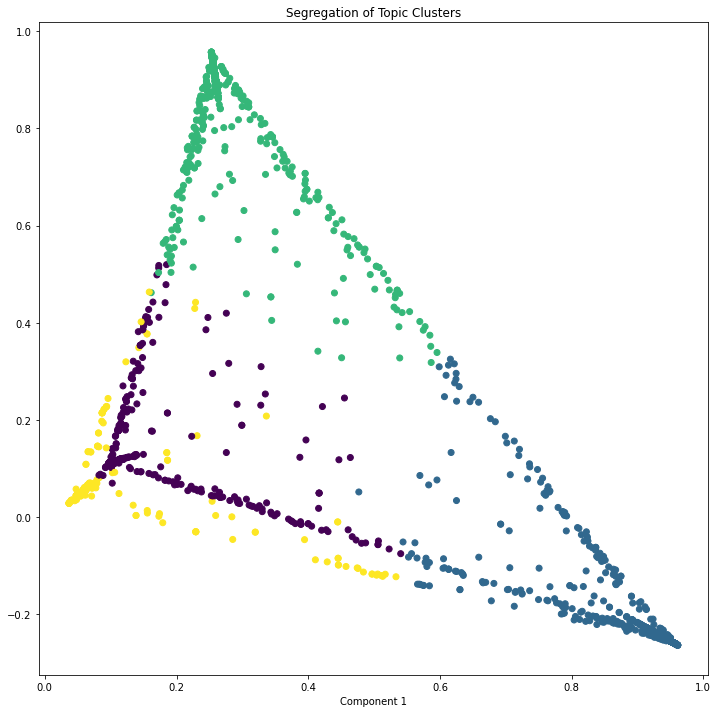

In [69]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## Save model

In [70]:
import pickle

with open("sklearn_lda_model.pk","wb") as f:
    pickle.dump(lda_model, f)

# then reload it with
# lda_model = pickle.load('sklearn_lda_model.pk')

In [71]:
#end